In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from utils import Encoder
from pytorch_lightning.callbacks import RichProgressBar
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from models import MultiClassJetNet
from datasets import SyntheticData

In [2]:
image_width = 80
image_height = 60

default_scalings = torch.tensor([[0.25, 0.25]])
encoder = Encoder(default_scalings, classes=["box"])

torch.manual_seed(2)
train_data = SyntheticData(image_width, image_height, 10000, encoder)
validation_data = SyntheticData(image_width, image_height, 1000, encoder)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=32, shuffle=False, drop_last=True)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="synthetic_data_logs/")


pl_model = MultiClassJetNet(encoder, 1e-3)
trainer = pl.Trainer(
    limit_predict_batches=100,
    max_epochs=20,
    callbacks=[RichProgressBar()],
    logger=tb_logger,
)
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ accuracy            │ MulticlassAccuracy │      0 │
│ 1 │ input_layer         │ NormConv2dReLU     │    146 │
│ 2 │ depth_wise_backbone │ Sequential         │  4.9 K │
│ 3 │ classifier          │ Sequential         │ 20.9 K │
│ 4 │ output_layer        │ Conv2d             │    150 │
└───┴─────────────────────┴────────────────────┴────────┘

Trainable params: 26.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.1 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/jonathan/hulks/ml/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:4
30: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/jonathan/hulks/ml/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:4
30: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=20` reached.


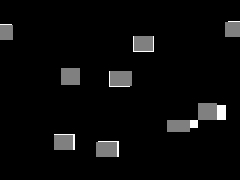

In [8]:
from visualize import draw_model_output, image_grid
import utils


grid_size = 3
image_list = []
for i in range(grid_size * grid_size):
    image, encoded_bounding_boxes, target_masks, encoded_target_classes = train_data[i]
    predicted_boxes, predicted_class_logits = pl_model(image.unsqueeze(0))
    predicted_classes = utils.calculate_predicted_classes(predicted_class_logits).squeeze()
    decoded_boxes = encoder.decode_bounding_boxes(predicted_boxes).squeeze()

    image_list.append(
        draw_model_output(
            image,
            decoded_boxes,
            predicted_classes,
            torch.tensor([0, 1]),
        )
    )
image_grid(image_list, grid_size, grid_size)
